# imports

In [1]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import re
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import random
import h5py
import os
import piq
from IPython.display import Image, HTML, Markdown, clear_output
from tqdm import tqdm_notebook, tnrange

!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 Laptop GPU (UUID: GPU-6cf8054c-6c04-c256-2ebb-8137cfc2e798)


In [2]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch import nn
from IPython.display import clear_output, display, HTML
import h5py
from pathlib import Path


import sys
sys.path.append("C:/Users/GAI/Desktop/Scott/NCA_Research")


from core_utils.plotting import *
from core_utils.utils_image import *
from core_utils.viz_train import *
from E4_PI_NCA.utils.helper import *
from E4_PI_NCA.utils.Dataset import *
from E4_PI_NCA.utils.PI_Metric import ScaledPhysicsMetrics

torch.set_default_device('cuda')

# heliper

In [3]:
def normalize_to_01(x):
    x_min, x_max = x.amin(dim=(1,2,3), keepdim=True), x.amax(dim=(1,2,3), keepdim=True)
    return (x - x_min) / (x_max - x_min + 1e-8)

def sperate_base_channels(x, base_channel_count=6):
    """將基礎通道與其他通道分離"""
    base_channels = x[:, :base_channel_count, :, :]
    other_channels = x[:, base_channel_count:, :, :]
    return base_channels, other_channels

# vgg loss

In [4]:
def pad_to_three_channels(img_slice):
    """
    將 1 或 2 個通道的張量填充/擴展成 3 個通道。
    輸入形狀: (B, C, H, W)，其中 C 是 1 或 2。
    輸出形狀: (B, 3, H, W)。
    """
    # B, C, H, W
    b, c, h, w = img_slice.shape
    
    if c == 3:
        # 已經是 3 通道，直接返回
        return img_slice
    elif c == 1:
        # 1 通道 (C_k) -> 複製 3 次 (C_k, C_k, C_k)
        return torch.cat([img_slice] * 3, dim=1)
    elif c == 2:
        # 2 通道 (C_k, C_{k+1}) -> 複製第一個通道作為第三個 (C_k, C_{k+1}, C_k)
        # 也可以複製第二個，這取決於您的設計，這裡我們複製第一個
        return torch.cat([img_slice, img_slice[:, 0:1, :, :]], dim=1)
    else:
        # 理論上不應該發生，因為我們每次取 3 個通道
        raise ValueError(f"Invalid number of channels for padding: {c}")

vgg16 = models.vgg16(weights='IMAGENET1K_V1').features

def calc_styles_vgg(imgs):
  style_layers = [1, 6, 11, 18, 25]
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
  x = (imgs-mean) / std
  b, c, h, w = x.shape
  features = [x.reshape(b, c, h*w)]
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      b, c, h, w = x.shape
      features.append(x.reshape(b, c, h*w))
  return features

def project_sort(x, proj):
  return torch.einsum('bcn,cp->bpn', x, proj).sort()[0]

def ot_loss(source, target, proj_n=32):
  ch, n = source.shape[-2:]
  projs = F.normalize(torch.randn(ch, proj_n), dim=0)
  source_proj = project_sort(source, projs)
  target_proj = project_sort(target, projs)
  target_interp = F.interpolate(target_proj, n, mode='nearest')
  return (source_proj-target_interp).square().sum()

def loss_f(imgs, target_img):
    """
    計算 N 通道圖像的風格損失，通過將通道拆分成 3 通道組。
    
    對於不足 3 個通道的最後一組，採用複製通道的方式補足為 3 通道。
    """
    total_loss = 0.0
    N = imgs.shape[1] # 總通道數
    
    # 設置每個 3 通道組的權重 (如果需要，可以在這裡調整不同組的權重)
    weight_per_group = 1.0 

    # --- 1. 迭代完整的 3 通道組 ---
    i = 0
    while i + 3 <= N:
        # 提取第 i, i+1, i+2 通道 (3 通道)
        imgs_slice = imgs[:, i:i+3, :, :]
        target_img_slice = target_img[:, i:i+3, :, :]
        
        # 計算風格損失
        yy = calc_styles_vgg(target_img_slice)
        xx = calc_styles_vgg(imgs_slice)
        group_loss = sum(ot_loss(x, y) for x, y in zip(xx, yy))
        
        total_loss += weight_per_group * group_loss
        
        i += 3 # 移動到下一組

    # --- 2. 處理剩餘的不足 3 個通道 (N mod 3 = 1 或 2) ---
    remaining_channels = N - i
    if remaining_channels > 0:
        # 提取剩餘的 1 或 2 個通道
        imgs_slice = imgs[:, i:N, :, :]
        target_img_slice = target_img[:, i:N, :, :]
        
        # 擴展成 3 個通道 (使用上面定義的邏輯)
        imgs_padded = pad_to_three_channels(imgs_slice)
        target_img_padded = pad_to_three_channels(target_img_slice)

        # 計算風格損失
        # ⚠️ 注意: 這裡使用的 VGG 標準化仍然是 ImageNet 的標準化。
        # 這假設您希望這最後 1 或 2 個通道在擴展後使用 ImageNet 的標準化參數。
        yy_padded = calc_styles_vgg(target_img_padded)
        xx_padded = calc_styles_vgg(imgs_padded)
        
        # 您可能需要調整最後一組的權重，因為它是複製通道得到的
        final_group_weight = 0.5 # 例如，給予較低的權重
        final_group_loss = sum(ot_loss(x, y) for x, y in zip(xx_padded, yy_padded))
        
        total_loss += final_group_weight * final_group_loss

    return total_loss

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

# NCA model

In [5]:
#@title Minimalistic Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
IDX_GEO_MASK = 2
def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = F.pad(y, [1, 1, 1, 1], 'circular')
  y = F.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
  return perchannel_conv(x, filters)

class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96):
    super().__init__()
    self.chn = chn
    self.w1 = nn.Conv2d(chn*4, hidden_n, 1)
    self.w2 = nn.Conv2d(hidden_n, chn, 1, bias=False)
    self.w2.weight.data.zero_()

  def forward(self, x, update_rate=0.5):
    y = perception(x)
    y = self.w2(torch.relu(self.w1(y)))
    b, c, h, w = y.shape
    udpate_mask = x[:,IDX_GEO_MASK:IDX_GEO_MASK+1]
    no_change = x[:, :6, :, :]
    updated = x + y * x[:, 2:3, :, :]
    return torch.cat([no_change, updated[:, 6:, :, :]], dim=1)

  def seed(self, n, sz=128):
    return torch.zeros(n, self.chn, sz, sz)

def to_rgb(x):
  return x[...,:3,:,:]+0.5

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 5856


關於loss項我有幾個問題，請更加詳細解釋:
1.U定義一致性：
$\ell$ 建議用 Huber 或 平滑 L1：對 noise 更健壯。
\ell 本身的用意是甚麼?Huber是甚麼 為甚麼要對nosie更健壯



# setup training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATASET_IMG_SIZE = (128,128)
dataset_dir = "../dataset_h5/train"
loaded_dataset,dataset_city_size = load_all_cases_to_BCHW(dataset_dir, target_size=DATASET_IMG_SIZE)
print(loaded_dataset.shape)


CHANNEL_C = 24
LERNING_RATE = 1e-3
POOL_SIZE = 256
# setup training
ca = CA(chn=CHANNEL_C).to(device)
opt = torch.optim.Adam(ca.parameters(), LERNING_RATE, capturable=True)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 2000], 0.3)
loss_log = []
metrics_log = []
# loaded_dataset = loaded_dataset[0:1]


gradient_checkpoints = False  # Set in case of OOM problems 

torch.Size([51, 11, 128, 128])


# training loop

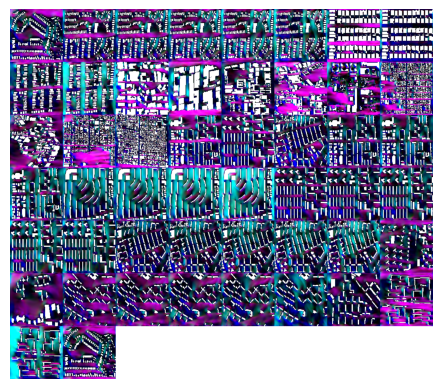

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9938965..1.0].


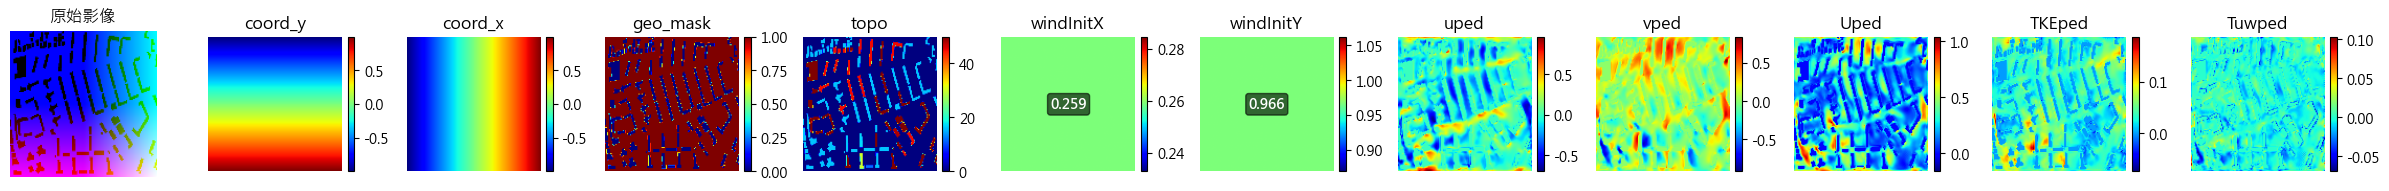

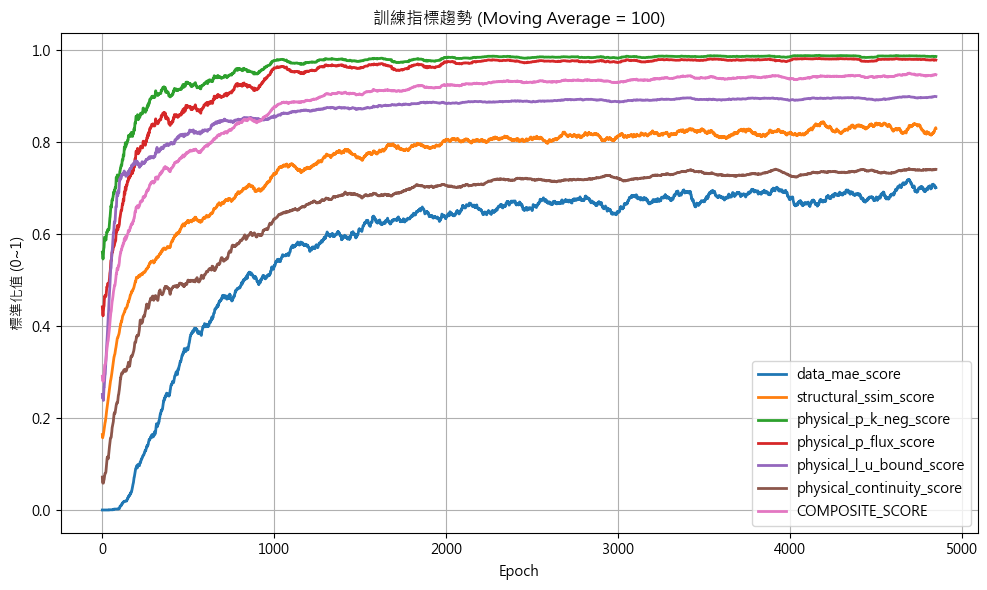

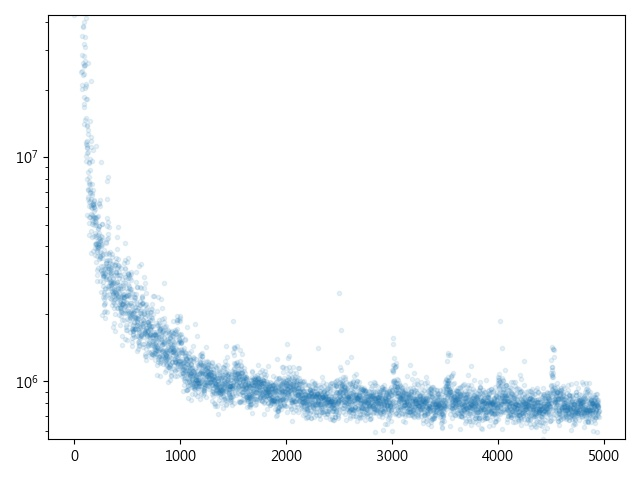

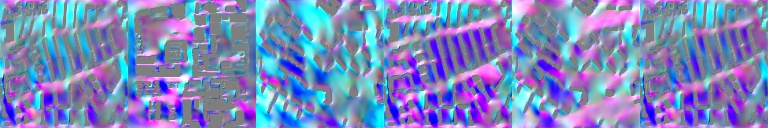

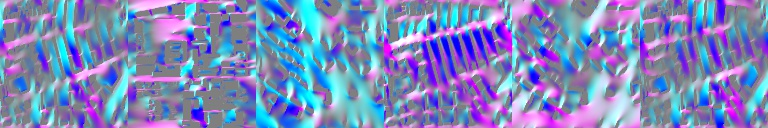

💾 已儲存新檢查點：..\outputs\E4-7.1_Init-NCA_20251102-153402/ca_model_step_4950.pth
✅ 已刪除舊檢查點：..\outputs\E4-7.1_Init-NCA_20251102-153402\ca_model_step_4800.pth
🗑️ 目前保留最新的 3 個檢查點。



        step_n: 4956
        loss: 740612.75
        lr: 8.999999999999999e-05


        step_n: 4961
        loss: 786226.875
        lr: 8.999999999999999e-05


        step_n: 4966
        loss: 675797.0
        lr: 8.999999999999999e-05


        step_n: 4971
        loss: 706239.625
        lr: 8.999999999999999e-05


        step_n: 4976
        loss: 810384.5
        lr: 8.999999999999999e-05


        step_n: 4981
        loss: 814943.0
        lr: 8.999999999999999e-05


        step_n: 4986
        loss: 807717.75
        lr: 8.999999999999999e-05


        step_n: 4991
        loss: 820642.25
        lr: 8.999999999999999e-05


        step_n: 4996
        loss: 777261.375
        lr: 8.999999999999999e-05

💾 已儲存新檢查點：..\outputs\E4-7.1_Init-NCA_20251102-153402/ca_model_step_5000.pth
✅ 已刪除舊檢查點：..\outputs\E4-7.1_Init-NCA_20251102-153402\ca_model_step_4850.pth
🗑️ 目前保留最新的 3 個檢查點。


In [7]:
# --- 模型儲存設定 (在訓練迴圈外定義) ---
# 假設您的模型物件是 ca，優化器是 opt
model_save_dir = get_output_path()  # 模型儲存的目錄路徑
model_name_format = "ca_model_step_{}.pth" # 模型檔案名稱的格式，包含當前步驟 i

# 假設 ca, opt, x_pool, y_pool, loss_f, lr_sched, metric_calculator, gradient_checkpoints, loss_log, metrics_log 等變數已定義並初始化

# 訓練迴圈
total_epochs =5000
for i in range(total_epochs):
    if i%500==0:
        x_pool, y_pool, pool_city_size = create_pool(loaded_dataset, dataset_city_size, pool_size=POOL_SIZE, channel_c=CHANNEL_C)
        x_pool, y_pool = x_pool.to(device), y_pool.to(device)
        metric_calculator = ScaledPhysicsMetrics(y_pool,pool_city_size)
    # ---- 1. 從池中取樣 (已在 GPU 上) ----
    with torch.no_grad():
        # 隨機選擇 6 個樣本的索引
        batch_idx = np.random.choice(len(x_pool), 6, replace=False)
        batch_city_size = [pool_city_size[i] for i in batch_idx.tolist()]
        # 複製選定的樣本，避免 in-place 操作污染原資料池
        x = x_pool[batch_idx].clone()
        y = y_pool[batch_idx]
        
        # 每 8 步將第一個樣本的非主要通道（從第 6 個通道開始）設為零
        if i % 8 == 0:
            x[:1, 6:, :, :] = 0

    # 隨機決定本次前向傳播的步數
    step_n = np.random.randint(32, 96)

    # ---- 2. 模型前向傳播 (Forward) ----
    if not gradient_checkpoints:
        # 如果不使用梯度檢查點，進行 step_n 次常規前向傳播
        for k in range(step_n):
            x = ca(x)
    else:
        # 如果使用梯度檢查點，需設定輸入需要梯度
        x.requires_grad = True
        # 使用 torch.utils.checkpoint 節省記憶體
        x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)

    # ---- 3. 損失計算 (Loss Calculation) ----
    # 計算溢出損失：確保 x 的值在 [-1.0, 1.0] 之間
    overflow_loss = (x - x.clamp(-1.0, 1.0)).abs().sum()
    # 總損失 = 主要損失 (第 6 到 10 個通道) + 溢出損失
    loss = loss_f(x[:,6:11], y[:,6:11]) + overflow_loss

    # ---- 4. 反向傳播與參數更新 (Backward & Update) ----
    opt.zero_grad() # 清除舊的梯度
    loss.backward() # 計算梯度

    with torch.no_grad():
        # 梯度規範化 (Gradient Normalization)：將梯度除以其 L2 範數
        for p in ca.parameters():
            if p.grad is not None:
                # 避免除以零
                p.grad /= (p.grad.norm() + 1e-8)
        
        opt.step() # 根據梯度更新模型參數
        lr_sched.step() # 更新學習率排程器
        
        # 將更新後的樣本放回資料池，使用 detach() 避免計算圖殘留
        x_pool[batch_idx] = x.detach()

    # ---- 5. 記錄損失 (Logging Loss) ----
    loss_log.append(loss.item())

    # ---- 6. 指標計算 (Metric Calculation) ----
    with torch.no_grad():
        # 計算相關指標
        metrics_result = metric_calculator(x, y,batch_city_size)
        # 將指標結果移到 CPU
        metrics_result = to_device(metrics_result, "cpu")
        metrics_log.append(metrics_result)

    # ---- 7. 訓練狀態顯示 (每 5 步) ----
    if i % 5 == 0:
        # 使用 Markdown 格式化輸出當前訓練狀態
        display(Markdown(f"""
        step_n: {len(loss_log)}
        loss: {loss.item()}
        lr: {lr_sched.get_last_lr()[0]}"""), display_id='stats')

    # ---- 8. 視覺化與檢查點儲存 (每 50 步) ----
    if i % 50 == 0:
        clear_output(wait=True) # 清除輸出，方便更新視覺化結果
        
        # 視覺化資料池狀態
        viz_pool(x_pool, step_i=i)
        
        # 視覺化單一樣本的多通道
        plt_HWC_split_channels(to_HWC(x[0,:11]))
        
        # 視覺化指標趨勢
        metrics_log = to_device(metrics_log, "cpu")
        plt_metrics_dict(metrics_log, window=100)
        
        # 視覺化損失趨勢
        pl.plot(loss_log, '.', alpha=0.1)
        pl.yscale('log')
        pl.ylim(np.min(loss_log), loss_log[0])
        pl.tight_layout()
        imshow(grab_plot(), id='log') # 顯示損失圖

        # 視覺化批次輸入和目標
        imgs = to_rgb(x[:,6:,:,:]).permute([0, 2, 3, 1]).detach().cpu().numpy()
        imshow(np.hstack(imgs), id='batch')
        target_imgs = to_rgb(y[:,6:,:,:]).permute([0, 2, 3, 1]).detach().cpu().numpy()
        imshow(np.hstack(target_imgs), id='batch')

        # --- 模型儲存 (Save Model) ---
        # 構造儲存檔案的完整路徑
        save_checkpoint(ca, opt, i, f"{model_save_dir}/ca_model_step_{i}.pth")

        
save_checkpoint(ca, opt, total_epochs, f"{model_save_dir}/ca_model_step_{total_epochs}.pth")


# output video

In [8]:
test_x_pool, test_y_pool = create_pool(loaded_dataset, pool_size=256, channel_c=24)
test_x_pool, test_y_pool = test_x_pool.to(device), test_y_pool.to(device)
metric_calculator = ScaledPhysicsMetrics(test_y_pool)

with VideoWriter() as vid, torch.no_grad():
  batch_idx = np.random.choice(len(test_x_pool), 4, replace=False)
  test_x = test_x_pool[batch_idx].clone()  # clone 避免 in-place 污染
  test_y = test_y_pool[batch_idx]
  plt_HWC_split_channels(to_HWC(test_x[0,:11]))

  for k in tnrange(300, leave=False):
    step_n = min(2**(k//30), 8)
    for i in range(step_n):
      test_x[:] = ca(test_x)
    img = to_rgb(test_x[0,6:]).permute(1, 2, 0).cpu()
    vid.add(zoom(img, 2))

TypeError: create_pool() missing 1 required positional argument: 'city_size'